In [330]:
# import packages
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import icepyx as ipx 
import pandas as pd
import numpy as np
import h5py
import glob
import os

In [324]:
# define utility functions
def multiple_is2_requests(earthdata_email, earthdata_uid, 
                          data_dir, requests, subset, download, visualize, email):
    """
    function to loop through series of requests to get data
    """
    for req in requests:
        region = ipx.Query(req['short_name'], req['spatial_extent'], req['date_range'])
        if download==True:
            region.earthdata_login(earthdata_uid, earthdata_email)
            region.download_granules(data_dir,subset=subset,email=email)
        print(region.dataset)
        print(region.dates)
        print(region.start_time)
        print(region.end_time)
        print(region.dataset_version)
        print(region.spatial_extent)
        if visualize:
            region.visualize_spatial_extent()

def read_field(group, field):
    """
    generic field-reading function
    """
    data=np.array(group[field])
    bad=(data==group[field].attrs['_FillValue'])
    data[bad]=np.NaN
    return data

def read_ATL11(filename, pair):
    """
    ATL11 reader
    """
    with h5py.File(filename,'r') as h5f:
        latitude=read_field(h5f[pair],'latitude')
        longitude=read_field(h5f[pair],'longitude')
        h_corr=read_field(h5f[pair],'h_corr')
        h_corr_sigma=read_field(h5f[pair],'h_corr_sigma')
        h_corr_sigma_s=read_field(h5f[pair],'h_corr_sigma_systematic')
    # return the values
    return latitude, longitude, h_corr, np.sqrt(h_corr_sigma**2+h_corr_sigma_s**2)

def ps2ll(x, y):
    """
    Transform coordinates from Antarctic Polar Stereograph
    to geodetic (lon, lat) coordinates
    lon, lat = ps2ll(x, y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

In [331]:
# define input parameters for multiple_is2_requests function 
earthdata_email='your email here' # 'your email here'
earthdata_uid='your earthdata usernam' # 'your earthdata username'

# replace with your data directory file path:
data_dir='/Users/Name/pathtofile'

download=False # set download to True if you're ready to download the data:
subset=True
email=False # forgo email order receipts using kwarg email=False
visualize=True # visualize spatial extent of request(s)
requests=[
    {# data product requested
     'short_name' : 'ATL11',
     # bounding box in decimal degrees: 
     # lower left lon, lat, upper right lon, lat (lon: W is neg; lat: S is neg)
     'spatial_extent' : [-22.25, -79.93, -21.15, -79.75], # Slessor23 bounding box
     'date_range' : ['2020-01-01','2021-03-24']}]    

In [ ]:
# download data (set download=True in previous cell)
multiple_is2_requests(earthdata_email, earthdata_uid, data_dir, requests, 
                      subset, download, visualize, email)

In [335]:
# grab ATL11 files
files=glob.glob(os.path.join(data_dir, 'ATL11*01.h5'))

# create empty lists
lat=[]
lon=[]
h_corr=[]
sigma_h=[]

# fill lists
for file in files:
    try:
        for pair in ['pt1','pt2','pt3']:
            lats, lons, hh, ss=read_ATL11(file, pair)
            lat += [lats]
            lon += [lons]
            h_corr += [hh]
            sigma_h += [ss]
    except Exception as E:
        pass
    
# concatenate lists
lat=np.concatenate(lat)
lon=np.concatenate(lon)
h_corr=np.concatenate(h_corr, axis=0)
sigma_h=np.concatenate(sigma_h, axis=0)

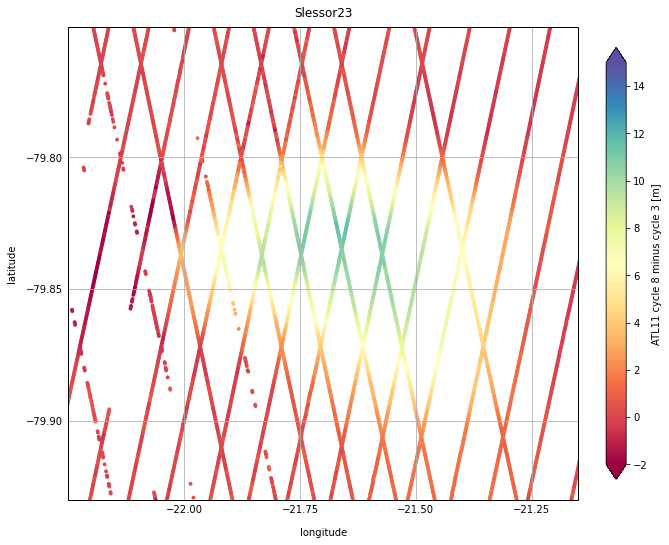

In [336]:
#projection=ccrs.SouthPolarStereo()
#projection = ccrs.Stereographic(central_longitude=0.0,
 #   central_latitude=-90,true_scale_latitude=-71.0)
projection=ccrs.Mercator() # selected project to use gridline method below
# create figure
fig,ax = plt.subplots(figsize=[10, 10])
ax = plt.axes(projection=projection)
sc = ax.scatter(lon[:], lat[:], s=15, c=h_corr[:,5]-h_corr[:,0],
    vmin=-2, vmax=15, 
    cmap='Spectral', edgecolors='none',
    transform=ccrs.PlateCarree())
hb = fig.colorbar(sc,ax=ax,extend='both',extendfrac=0.0375,drawedges=False,fraction=0.036, pad=0.05)
hb.set_label('ATL11 cycle 8 minus cycle 3 [m]')
#ax.coastlines('10m')
#ax.set_extent([-180, 180, -60, -90], ccrs.PlateCarree()) # AnIS
ax.set_extent([-22.25, -21.15, -79.93, -79.75], crs=ccrs.PlateCarree()) # Slessor23 bounding box
gl = ax.gridlines(draw_labels=True) #, dms=True, x_inline=False, y_inline=False)
gl.xlocator = mticker.FixedLocator([-22.25, -22, -21.75, -21.5, -21.25, -21])
gl.ylocator = mticker.FixedLocator([-79.75, -79.8, -79.85, -79.9, -79.95])
gl.xlabels_top = False
gl.ylabels_right = False
plt.title("Slessor23", pad=10)
ax.text(0.5, -0.08, 'longitude', va='bottom', ha='center', # x label workaround in Cartopy
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(-0.1, 0.5, 'latitude', va='bottom', ha='center', 
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
plt.show()

In [337]:
# transform geodetic lon, lat to polar stereographic x, y
x, y = ll2ps(lon, lat)

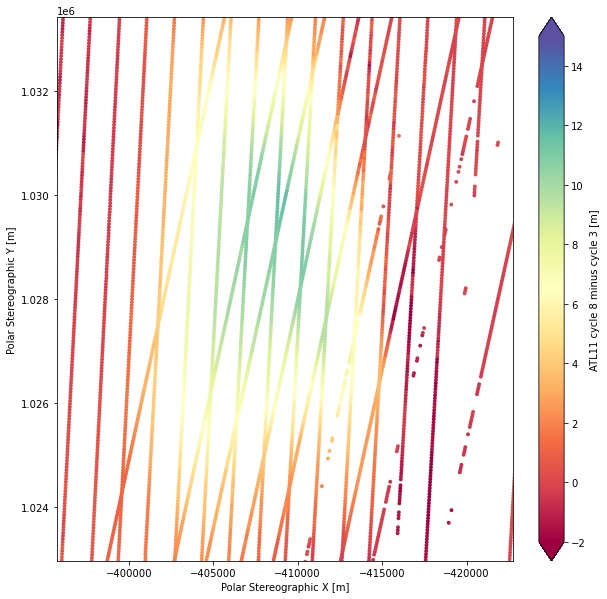

In [338]:
plt.figure(figsize = (20,10))
ax = plt.subplot(121)
plt.scatter(x, y, s=15, c=h_corr[:,5]-h_corr[:,0],
    vmin=-2, vmax=15, 
    cmap='Spectral', edgecolors='none')
#plt.axis('equal')
plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]');
x1, y1 = ll2ps(-21.15, -79.93); # Slessor23 bounding box
x2, y2 = ll2ps(-22.25, -79.75);
ax.set_xlim([x1, x2]);
ax.set_ylim([y1, y2]);
cbar = fig.colorbar(sc,ax=ax,extend='both',extendfrac=0.0375,drawedges=False,fraction=0.05, pad=0.05)
cbar.set_label('ATL11 cycle 8 minus cycle 3 [m]')

In [339]:
# export lat, lon, and h_corr to pandas dataframe for alternate plotting methods
# h_corr columns are cycles
dataset = pd.DataFrame(np.hstack((lat[:, None], lon[:, None], h_corr)))
dataset.head

<bound method NDFrame.head of                  0           1            2            3            4   5  \
0       -79.006341  -19.617471  1247.015503  1247.008301  1247.096191 NaN   
1       -79.006864  -19.618044  1246.914795  1246.914307  1246.992920 NaN   
2       -79.007392  -19.618499  1246.690552  1246.749634  1246.815674 NaN   
3       -79.007916  -19.619043  1246.633911  1246.708252  1246.792114 NaN   
4       -79.008440  -19.619580  1246.510254  1246.550415  1246.623779 NaN   
...            ...         ...          ...          ...          ...  ..   
1708388 -78.996805  179.059504          NaN    -5.351668          NaN NaN   
1708389 -78.996281  179.058952          NaN    -5.343719          NaN NaN   
1708390 -78.995757  179.058400          NaN    -5.344772          NaN NaN   
1708391 -78.995233  179.057848          NaN    -5.338536          NaN NaN   
1708392 -78.994708  179.057296          NaN    -5.346765          NaN NaN   

                   6            7  
0        

In [340]:
# save dataframe to current working directory
dataset.to_csv("ATL11data.csv")